In [1]:
from transformer_lens import HookedTransformer
import transformer_lens
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import transformer_lens.utils as utils
import hashlib
import yaml 
import hashlib
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [3]:
device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [4]:
weight_vectors = np.load('layer_analyses/combined_delta_vectors.npy')

In [5]:
import matplotlib.pyplot as plt

def plot_head_attention_maps(model, layer_idx: int, head_idx: int, prompt1: str, prompt2: str, plot=True):
    """
    Runs both prompts through the model with cache, extracts the attention map
    for the given (layer_idx, head_idx), and plots them side‑by‑side with token labels.
    
    Args:
        model:        A HookedTransformer from transformer_lens
        layer_idx:    0‑indexed layer number
        head_idx:     0‑indexed head number within that layer
        prompt1:      First prompt string
        prompt2:      Second prompt string
    Returns:
        attn1, attn2: torch.Tensor of shape (seq_len, seq_len) for each prompt
    """
    model.eval()
    def get_attn_and_labels(prompt):
        tokens = model.to_tokens(prompt)                 # [1, seq_len]
        token_ids = tokens[0].tolist()                   # list of ints
        # get token strings one-by-one
        labels = [model.to_string([tid]).strip() 
                  for tid in token_ids]
        
        _, cache = model.run_with_cache(tokens)
        patterns = cache["pattern", layer_idx]           # [1, heads, seq, seq]
        attn = patterns[0, head_idx].detach().cpu()      # [seq, seq]
        return attn, labels

    attn1, labels1 = get_attn_and_labels(prompt1)
    attn2, labels2 = get_attn_and_labels(prompt2)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        for ax, attn, labels, title in zip(
            axes,
            (attn1, attn2),
            (labels1, labels2),
            ("Thinking prompt", "Answering prompt")
        ):
            im = ax.imshow(attn, aspect='auto')
            ax.set_title(f'Head ({layer_idx}, {head_idx}) – {title}')
            ax.set_xticks(range(len(labels)))
            ax.set_yticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=90, fontsize=8)
            ax.set_yticklabels(labels, fontsize=8)
            ax.set_xlabel("Key position")
            ax.set_ylabel("Query position")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

    return attn1, attn2


now we'll make a 

In [6]:
def generate_think_and_immediate_answer_prompts(
        model: HookedTransformer,
        prompt: str,
):
    # wrap prompt in chat format
    chat = [{"role": "user", "content": prompt}]

    # 1) THINK prefix
    think_prefix = model.tokenizer.apply_chat_template(
        chat, add_generation_prompt=True, tokenize=False
    )

    # 2) ANSWER prefix (greedy to </think>)
    answer_prefix = think_prefix + "\n</think>\n\n"


    if answer_prefix[:len("<｜begin▁of▁sentence｜>"):] == "<｜begin▁of▁sentence｜>":
        answer_prefix = answer_prefix[len("<｜begin▁of▁sentence｜>"):]
    if think_prefix[:len("<｜begin▁of▁sentence｜>"):] == "<｜begin▁of▁sentence｜>":
        think_prefix = think_prefix[len("<｜begin▁of▁sentence｜>"):]
    return think_prefix, answer_prefix

In [7]:
think_prefix, answer_prefix = generate_think_and_immediate_answer_prompts(
    model,
    "What is the fifth prime?"
)
think_prefix, answer_prefix

('<｜User｜>What is the fifth prime?<｜Assistant｜><think>\n',
 '<｜User｜>What is the fifth prime?<｜Assistant｜><think>\n\n</think>\n\n')

/tmp/ipykernel_18627/3803017480.py:51: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


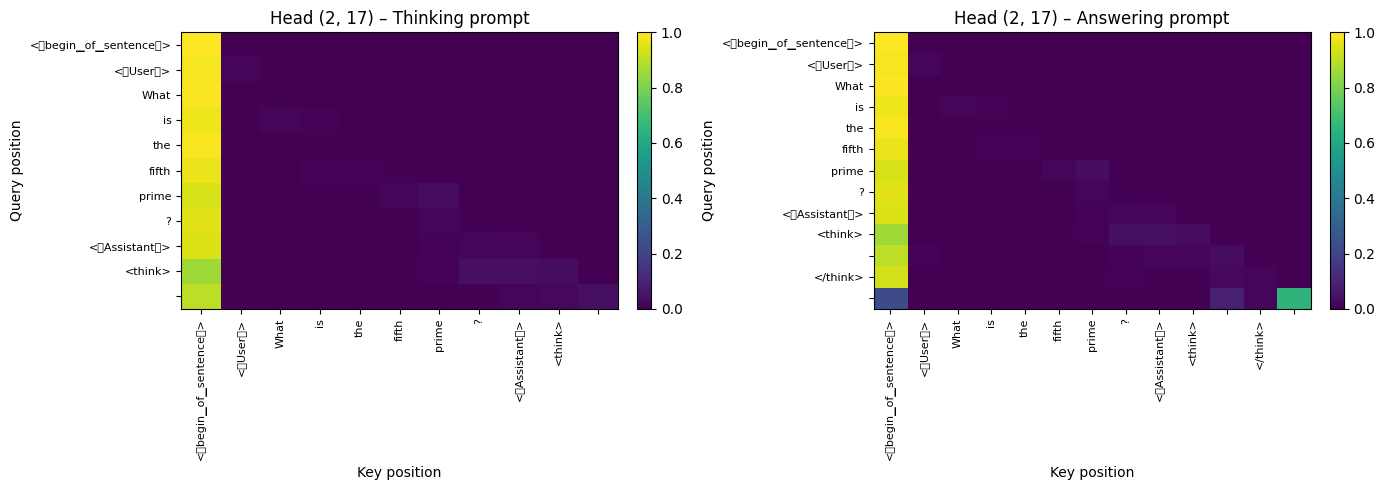

In [8]:
layer_idx=2 
head_idx = 17

attn_think, attn_ans = plot_head_attention_maps(model, layer_idx, head_idx, prompt1=think_prefix, prompt2=answer_prefix)


is it responding to a particular head?

i want to know, what does it respond to most 

In [9]:
layer_idx=2
head_idx = 17   
K = model.blocks[layer_idx].attn.W_K[head_idx]
Q = model.blocks[layer_idx].attn.W_Q[head_idx]

K.shape, Q.shape

QK_prod = torch.einsum('i j, k j -> i k', Q, K)

What is the input to this head?

In [10]:


def get_resid_pre(
    model: HookedTransformer,
    prompt: str | list[int] | torch.Tensor,
    layer: int,
    pos: int,
) -> torch.Tensor:
    """
    Return the residual stream (pre‐attention) at a specific layer and token position.

    Args:
        model  : a loaded HookedTransformer
        prompt : raw string (will be tokenized) or a tensor of shape [1, seq_len]
        layer  : which transformer block (0-indexed)
        pos    : which token position in the sequence (0-indexed)

    Returns:
        Tensor of shape (d_model,) giving resid_pre at that position.
    """
    # Tokenize to [1, seq_len]
    if isinstance(prompt, str):
        toks = model.to_tokens(prompt).to(device=model.cfg.device)
    else:
        toks = prompt if prompt.ndim == 2 else prompt.unsqueeze(0)
        toks = toks.to(device=model.cfg.device)

    stored = {}
    def save_resid_pre(x, hook):
        # x: [batch, seq_len, d_model]
        stored["resid_pre"] = x.detach().cpu()

    hook_name = utils.get_act_name('resid_pre', layer, None)
    _ = model.run_with_hooks(
        toks,
        fwd_hooks=[(hook_name, save_resid_pre)],
    )

    # extract [batch=0, pos, :]
    return stored["resid_pre"][0, pos, :]



In [11]:
head_input = get_resid_pre(
    model,
    prompt=answer_prefix,
    layer=2,
    pos=-1,
).to(Q)

In [12]:
QK_prod.shape

torch.Size([4096, 4096])

In [13]:
head_input.to(QK_prod) @ QK_prod @ head_input.to(QK_prod)

tensor(0.2230, device='cuda:0')

In [14]:
answer_prefix

'<｜User｜>What is the fifth prime?<｜Assistant｜><think>\n\n</think>\n\n'

In [15]:
model.W_U.shape

torch.Size([4096, 128256])

In [16]:
# compute cosine similarity of head_input with \n\n embedding vector 
nn_embedding = model.W_U[:, model.to_tokens(answer_prefix)[0, -1].item()]
head_input = head_input.to(nn_embedding)


In [17]:
def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two vectors.
    """
    a = a / a.norm(dim=-1, keepdim=True)
    b = b / b.norm(dim=-1, keepdim=True)
    return torch.dot(a, b).item()

In [18]:
head_input = get_resid_pre(
    model,
    prompt=answer_prefix,
    layer=2,
    pos=-1,
).to(Q)

In [19]:
tokens = model.to_tokens(answer_prefix)

activations = {}

def make_hook(name):
    def hook_fn(value, hook):
        # Detach and move to CPU to save GPU memory
        activations[name] = value.detach().cpu()
        return value
    return hook_fn

# Determine how many layers to collect
n_layers = 3

# Build list of (hook_name, hook_fn) tuples
hooks = []
# 1) Embed hook — captures post-embedding activations
hooks.append(("hook_embed", make_hook("hook_embed")))
# 2) resid_pre hooks for each layer
for layer in range(n_layers):
    # 2) resid_pre (before attention and MLP)
    hooks.append((utils.get_act_name("resid_pre", layer), make_hook(f"resid_pre_{layer}")))

    # 3) attn_out (output of all heads combined)
    hooks.append((utils.get_act_name("attn_out", layer), make_hook(f"attn_out_{layer}")))

    # 4) resid_mid (after attention, before MLP)
    hooks.append((utils.get_act_name("resid_mid", layer), make_hook(f"resid_mid_{layer}")))

    # 5) resid_post (after MLP, before next layer)
    hooks.append((utils.get_act_name("resid_post", layer), make_hook(f"resid_post_{layer}")))


# Run the model with forward hooks (uses much less memory than run_with_cache)
_ = model.run_with_hooks(tokens, fwd_hooks=hooks)

In [20]:
head_input_cos_sims = [{} for _ in range(n_layers)]

for key in activations:
    if key.startswith("resid"):
        # then what layer is it, and what is the coside similarity with the head_input
        layer = int(key.split("_")[-1]) 
        head_input_cos_sims[layer][key] = cosine_similarity(
            activations[key][0, -1, :].to(Q), head_input
        )

In [21]:
for layer_idx, acts in enumerate(head_input_cos_sims):
    print(f"Layer {layer_idx}:")
    for key, cos_sim in acts.items():
        print(f"  {key}: {cos_sim:.4f}")
    print()

Layer 0:
  resid_pre_0: 0.1803
  resid_mid_0: 0.5811
  resid_post_0: 0.7479

Layer 1:
  resid_pre_1: 0.7479
  resid_mid_1: 0.8306
  resid_post_1: 1.0000

Layer 2:
  resid_pre_2: 1.0000
  resid_mid_2: 0.6851
  resid_post_2: 0.6103



In [23]:
attn_think, attn_ans = plot_head_attention_maps(
                model, layer_idx, head_idx, prompt1=think_prefix, prompt2=answer_prefix, plot=False
            )

In [29]:
attn_think.cpu().shape

torch.Size([11, 11])

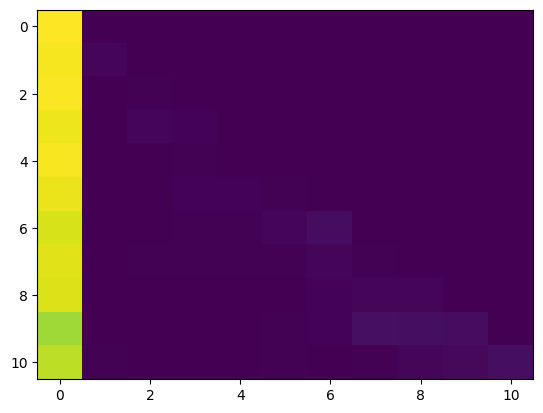

In [25]:
plt.imshow(attn_think.cpu(), aspect='auto')

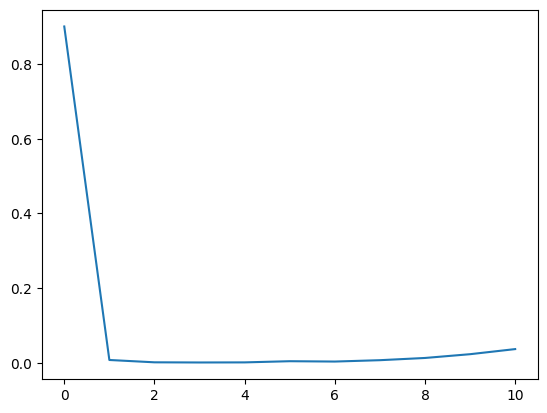

In [31]:
plt.plot(attn_think.cpu()[-1, :])

In [37]:
def sweep_for_attention_increase(
    model, 
    think_prefix, 
    answer_prefix, 
    layer_idxs,
    attention_mask
):
    """ 
    below, im interested in finding which attention heads increased their attention 
    on the final final_token_num tokens of the answer_prefix vs the think prefix

    use the absolute magnsitude of the difference between the two attention maps
    over the final final_token_num tokens of the answer_prefix 

    sweep over all heads in the layer_idxs (a list of layer indices)

    return a heatmap of the attention increase for each head in each layer
    and a dictionary mapping (layer, head) to the attention increase
    """
    layer_head_attn_increase = {}
    for layer_idx in layer_idxs:
        for head_idx in range(model.cfg.n_heads):
            attn_think, attn_ans = plot_head_attention_maps(
                model, layer_idx, head_idx, prompt1=think_prefix, prompt2=answer_prefix, plot=False
            )
            # extract 
            layer_head_attn_increase[(layer_idx, head_idx)] = (attn_think.cpu()[-1,:]*attention_mask).sum()
    
    # plot the heatmap
    fig, ax = plt.subplots(figsize=(10, 5))
    heatmap = np.zeros((len(layer_idxs), model.cfg.n_heads))
    for (layer_idx, head_idx), attn_increase in layer_head_attn_increase.items():
        heatmap[layer_idx, head_idx] = attn_increase.item()
    im = ax.imshow(heatmap, aspect='auto', cmap='hot')
    ax.set_xticks(range(model.cfg.n_heads))
    ax.set_yticks(range(len(layer_idxs)))
    ax.set_xticklabels(range(model.cfg.n_heads))
    ax.set_yticklabels(layer_idxs)
    ax.set_xlabel("Head index")
    ax.set_ylabel("Layer index")
    ax.set_title("Attention increase on final tokens")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    # return the layer_head_attn_increase dictionary
    # and the heatmap
    # return the layer_head_attn_increase dictionary
    # and the heatmap
    return layer_head_attn_increase



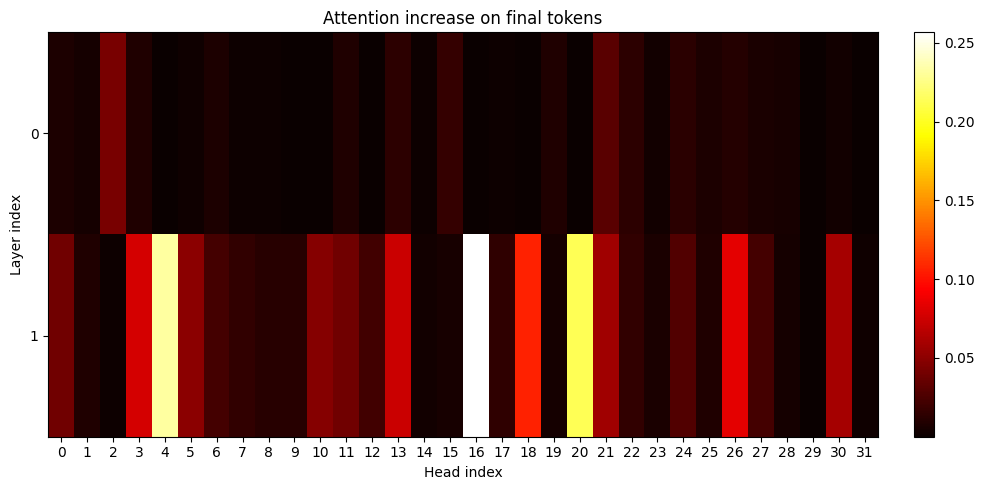

In [39]:
layer_idxs = [0, 1]
attention_mask = torch.zeros(11)
attention_mask[-2] = 1
layer_head_attn_increase = sweep_for_attention_increase(
    model, 
    think_prefix, 
    answer_prefix, 
    layer_idxs,
    attention_mask,
)

In [ ]:
layer_idxs = [0, 1]
attention_mask = torch.zeros(11)
attention_mask[-2] = 1
layer_head_attn_increase = sweep_for_attention_increase(
    model, 
    think_prefix, 
    answer_prefix, 
    layer_idxs,
    attention_mask,
)

/tmp/ipykernel_18627/3803017480.py:51: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


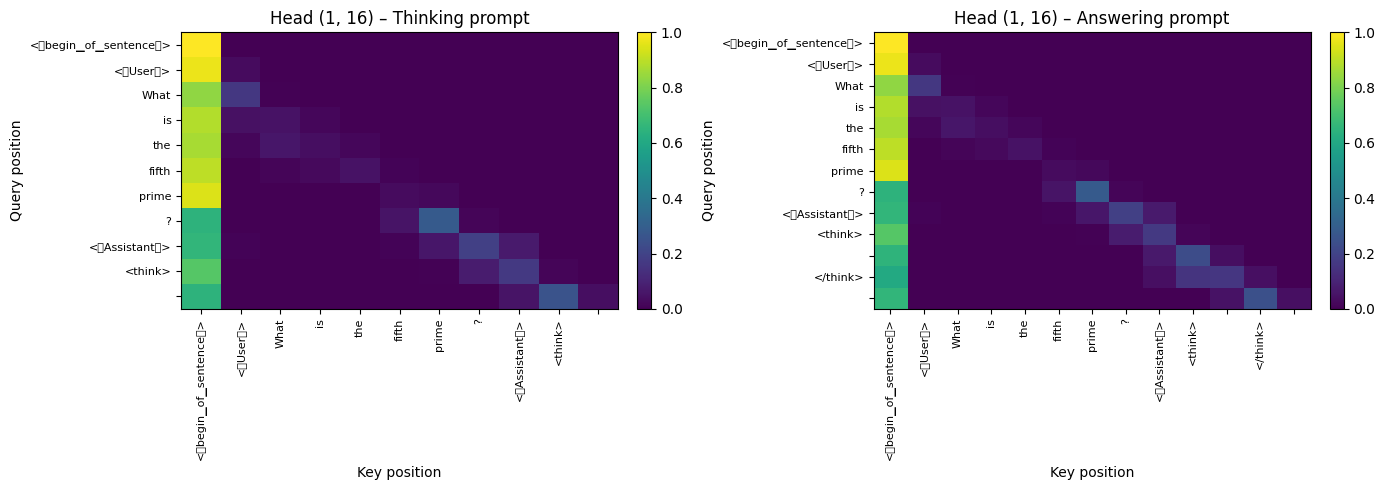

In [41]:
head_idx = 16
layer_idx = 1

attn_think, attn_ans = plot_head_attention_maps(
    model, layer_idx, head_idx, prompt1=think_prefix, prompt2=answer_prefix, plot=True
)

/tmp/ipykernel_17452/4242568328.py:50: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


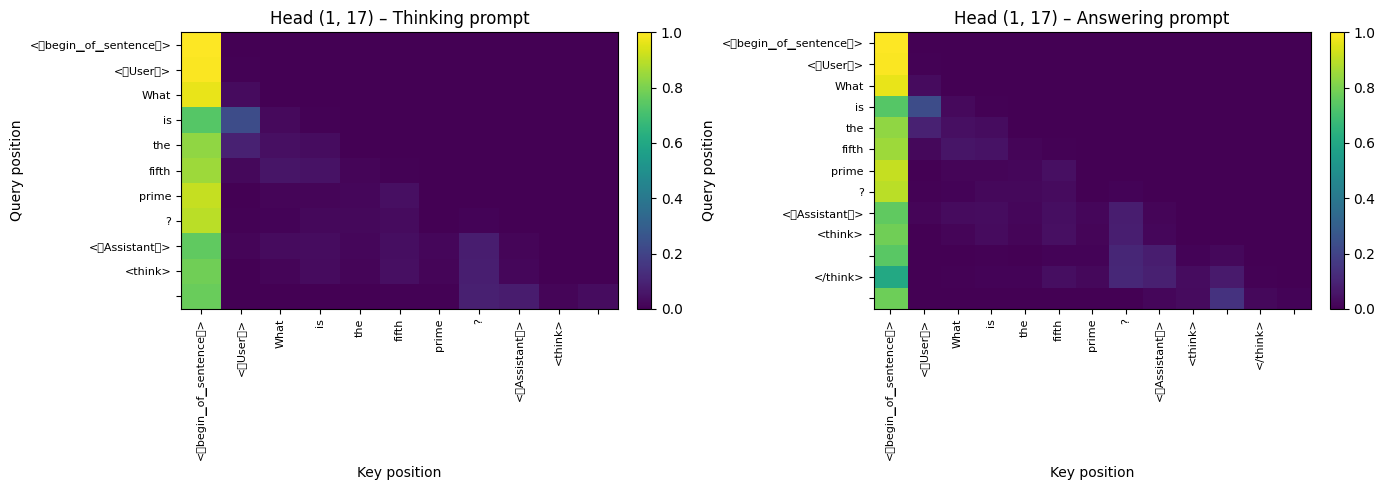

In [ ]:
layer_idx=1 
head_idx = 17

attn_think, attn_ans = plot_head_attention_maps(model, layer_idx, head_idx, prompt1=think_prefix, prompt2=answer_prefix)

In [ ]:

def plot_embedding_resid_pre_cosine_heatmap_with_hooks(
    model: HookedTransformer,
    prompt: str,
    layer_count: int = None,
    figsize: tuple = (12, 6)
):
    """
    Run the model on `prompt`, capture the embedding and resid_pre activations
    via forward hooks, compute cosine similarity between embedding and resid_pre
    for each layer, and plot a heatmap.

    Args:
        model: HookedTransformer instance (already on the right device).
        prompt: Input text string.
        layer_count: Number of layers to include (defaults to model.cfg.n_layers).
        figsize: Size of the matplotlib figure.
    """
    # Tokenize the prompt
    tokens = model.to_tokens(prompt)  # [1, seq_len]

    # Storage for hooked activations
    activations = {}

    def make_hook(name):
        def hook_fn(value, hook):
            # Detach and move to CPU to save GPU memory
            activations[name] = value.detach().cpu()
            return value
        return hook_fn

    # Determine how many layers to collect
    n_layers = model.cfg.n_layers if layer_count is None else layer_count

    # Build list of (hook_name, hook_fn) tuples
    hooks = []
    # 1) Embed hook — captures post-embedding activations
    hooks.append(("hook_embed", make_hook("hook_embed")))
    # 2) resid_pre hooks for each layer
    for layer in range(n_layers):
        act_name = utils.get_act_name("resid_pre", layer, None)
        hooks.append((act_name, make_hook(act_name)))

    # Run the model with forward hooks (uses much less memory than run_with_cache)
    _ = model.run_with_hooks(tokens, fwd_hooks=hooks)

    # Extract the embedding [1, seq_len, d_model] → [seq_len, d_model]
    embed = activations["hook_embed"][0]
    seq_len, d_model = embed.shape

    # Compute cosine similarities
    sims = []
    for layer in range(n_layers):
        act_name = utils.get_act_name("resid_pre", layer, None)
        resid_pre = activations[act_name][0]  # [seq_len, d_model]
        cos = torch.nn.functional.cosine_similarity(embed, resid_pre, dim=-1)
        sims.append(cos.numpy())

    sim_matrix = np.stack(sims)  # [n_layers, seq_len]

    # Get human‑readable token strings
    token_strs = model.to_str_tokens(tokens[0])

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(sim_matrix, aspect="auto", interpolation="nearest")
    fig.colorbar(im, ax=ax, label="Cosine similarity")

    ax.set_xticks(np.arange(seq_len))
    ax.set_xticklabels(token_strs, rotation=90, fontsize=8)
    ax.set_yticks(np.arange(n_layers))
    ax.set_yticklabels([f"L{l}" for l in range(n_layers)])
    ax.invert_yaxis()
    ax.set_xlabel("Token")
    ax.set_ylabel("Layer (resid_pre)")
    ax.set_title("Embedding ↔ resid_pre Cosine Similarity Heatmap")
    plt.tight_layout()
    plt.show()

In [ ]:
answer_prefix

'<｜User｜>What is the fifth prime?<｜Assistant｜><think>\n\n</think>\n\n'

/tmp/ipykernel_17452/2753217162.py:76: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


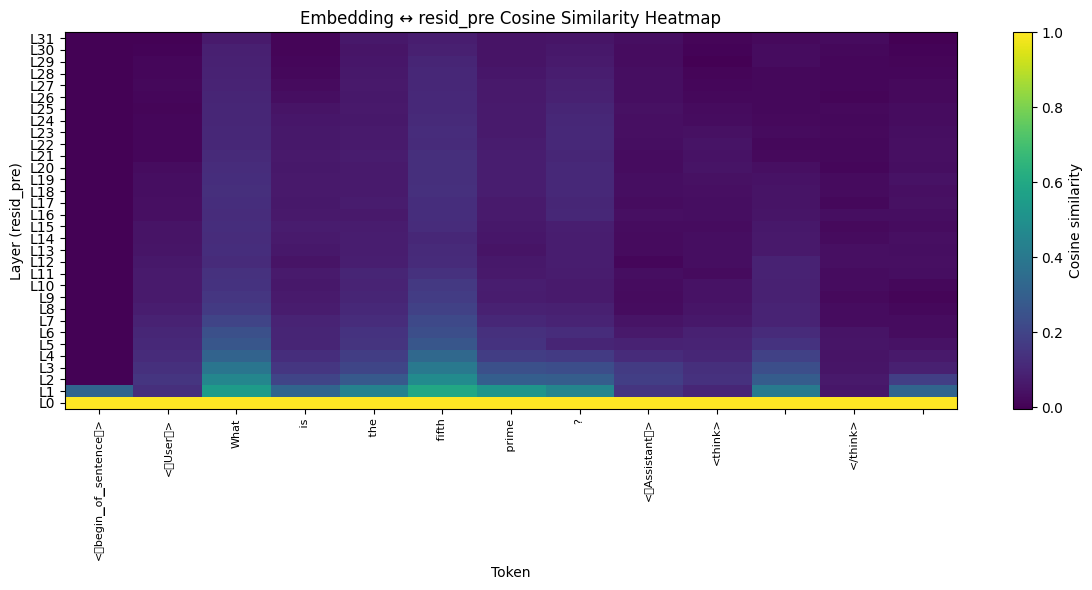

In [ ]:
 plot_embedding_resid_pre_cosine_heatmap_with_hooks(
    model,
    prompt=answer_prefix,
    layer_count=32,
    figsize= (12, 6)
)

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import transformer_lens.utils as utils
from transformer_lens.HookedTransformer import HookedTransformer

def sweep_attention_substitution_effect(
    model: HookedTransformer,
    target_layer: int,
    target_head: int,
    target_prompt: str,
    corrupted_prompt: str,
    device: str = None,
    figsize: tuple = (10, 5)
):
    """
    Substitute each clean head‐output into the corrupted run one at a time,
    and measure the L2‐norm change in the target_layer/target_head output
    at the final token only.

    Returns:
      layer_head_change: dict[(layer, head)] -> float change magnitude
      heatmap          : np.ndarray shape (target_layer, n_heads)
    """
    device = device or next(model.parameters()).device
    model = model.to(device)

    # 1) Tokenize
    toks_clean = model.to_tokens(target_prompt).to(device)
    toks_corr  = model.to_tokens(corrupted_prompt).to(device)

    # 2) Collect clean per-head "z" for layers < target_layer
    clean_z = {}  # clean_z[L] = tensor [1, seq_clean, n_heads, head_dim] on CPU
    hooks_clean = []
    for L in range(target_layer):
        act_z = utils.get_act_name("z", L, None)
        def make_clean_hook(L):
            def hook_fn(z, hook):
                clean_z[L] = z.detach().cpu()
                return z
            return hook_fn
        hooks_clean.append((act_z, make_clean_hook(L)))
    _ = model.run_with_hooks(toks_clean, fwd_hooks=hooks_clean)

    # 3) Baseline vector at (target_layer, target_head) for corrupted run
    baseline = None
    act_z_tgt = utils.get_act_name("z", target_layer, None)
    def hook_baseline(z, hook):
        nonlocal baseline
        baseline = z.detach()[0, -1, target_head, :].cpu()
        return z

    _ = model.run_with_hooks(toks_corr, fwd_hooks=[(act_z_tgt, hook_baseline)])
    # baseline is [head_dim]
    
    # 4) Sweep: patch only the **final token** head‐output
    layer_head_change = {}
    n_heads = model.cfg.n_heads

    for L in range(target_layer):
        # extract clean final‐token slice for this layer as a CPU tensor
        # shape: [n_heads, head_dim]
        clean_final = clean_z[L][0, -1, :, :]  

        for H in range(n_heads):
            # the clean vector for head H at layer L
            clean_vec = clean_final[H]  # [head_dim]

            # patch hook that only overwrites z[..., -1, H, :] on the corrupted run
            def make_patch_fn(clean_vec, H):
                def patch_fn(z, hook):
                    z = z.clone()  # [1, seq_corr, n_heads, head_dim]
                    z[0, -1, H, :] = clean_vec.to(device)
                    return z
                return patch_fn

            # capture the patched target output at the final token
            patched_vec = None
            def hook_capture(z, hook):
                nonlocal patched_vec
                patched_vec = z.detach()[0, -1, target_head, :].cpu()
                return z

            phooks = [
                (utils.get_act_name("z", L, None), make_patch_fn(clean_vec, H)),
                (act_z_tgt, hook_capture),
            ]
            _ = model.run_with_hooks(toks_corr, fwd_hooks=phooks)

            # compute L2 change at final token
            change = float((patched_vec - baseline).norm())
            layer_head_change[(L, H)] = change

    # 5) Build heatmap array
    heatmap = np.zeros((target_layer, n_heads), dtype=float)
    for (L, H), val in layer_head_change.items():
        heatmap[L, H] = val

    # 6) Plot with layer 0 at bottom
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(heatmap, aspect="auto", interpolation="nearest")
    ax.set_xticks(np.arange(n_heads))
    ax.set_xticklabels(np.arange(n_heads))
    ax.set_yticks(np.arange(target_layer))
    ax.set_yticklabels(np.arange(target_layer))
    ax.invert_yaxis()
    ax.set_xlabel("Head index")
    ax.set_ylabel("Layer index")
    ax.set_title(
        f"L₂ change at L{target_layer}H{target_head} (final token)"
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    return layer_head_change, heatmap


Moving model to device:  cuda:0


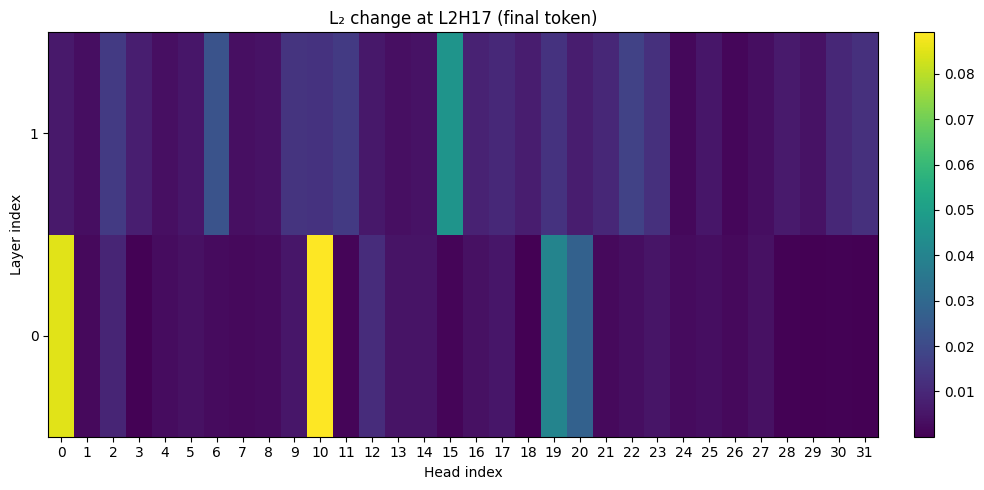

({(0, 0): 0.08503897488117218,
  (0, 1): 0.0023507094010710716,
  (0, 2): 0.009318934753537178,
  (0, 3): 0.00053664535516873,
  (0, 4): 0.0030577757861465216,
  (0, 5): 0.003953664097934961,
  (0, 6): 0.002489392412826419,
  (0, 7): 0.002376253018155694,
  (0, 8): 0.0027278116904199123,
  (0, 9): 0.0053308336064219475,
  (0, 10): 0.08916100114583969,
  (0, 11): 0.0013623886043205857,
  (0, 12): 0.011313220486044884,
  (0, 13): 0.004763999488204718,
  (0, 14): 0.004821885842829943,
  (0, 15): 0.0012186350068077445,
  (0, 16): 0.003867238759994507,
  (0, 17): 0.005262504331767559,
  (0, 18): 0.0003139406908303499,
  (0, 19): 0.04033973813056946,
  (0, 20): 0.027522483840584755,
  (0, 21): 0.002422281773760915,
  (0, 22): 0.003340682713314891,
  (0, 23): 0.005105898249894381,
  (0, 24): 0.00244689779356122,
  (0, 25): 0.003212936455383897,
  (0, 26): 0.002222322626039386,
  (0, 27): 0.0040495144203305244,
  (0, 28): 0.0005731162382289767,
  (0, 29): 6.636374746449292e-05,
  (0, 30): 0.00

In [58]:
sweep_attention_substitution_effect(
    model,
    target_layer=2,
    target_head=17,
    target_prompt=answer_prefix,
    corrupted_prompt=think_prefix,
    device='cuda:0',
    figsize= (10, 5)
)

/tmp/ipykernel_18627/3803017480.py:51: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


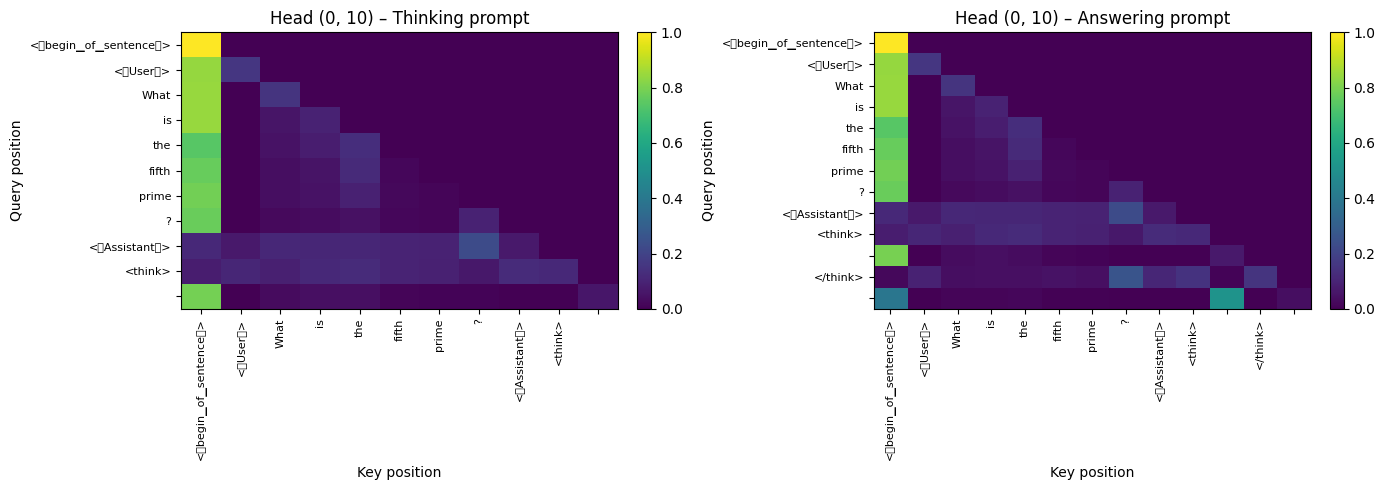

In [60]:
layer_idx=0
head_idx = 10

attn_think, attn_ans = plot_head_attention_maps(model, layer_idx, head_idx, prompt1=think_prefix, prompt2=answer_prefix)

In [49]:
sweep_head_patch_effects(model, 2, 17, answer_prefix, think_prefix)

KeyError: 'pattern'

In [ ]:
model.W_U

Parameter containing:
tensor([[ 0.0074, -0.0063,  0.0141,  ..., -0.0033, -0.0034, -0.0033],
        [ 0.0073,  0.0035,  0.0064,  ...,  0.0031,  0.0031,  0.0031],
        [ 0.0096,  0.0189,  0.0152,  ...,  0.0029,  0.0029,  0.0029],
        ...,
        [ 0.0105, -0.0029,  0.0034,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0211,  0.0059, -0.0103,  ...,  0.0080,  0.0080,  0.0080],
        [-0.0141, -0.0030, -0.0162,  ...,  0.0085,  0.0085,  0.0085]],
       device='cuda:0', requires_grad=True)

In [ ]:
model.W_U.shape, nn_embedding.shape

(torch.Size([4096, 128256]), torch.Size([4096, 128256]))

In [ ]:
# compute svd on Query and Key matrices

def compute_svd(matrix):
    """
    Computes the SVD of a given matrix and returns the singular values and vectors.
    
    Args:
        matrix (torch.Tensor): The input matrix to compute SVD on.
        
    Returns:
        U (torch.Tensor): Left singular vectors.
        S (torch.Tensor): Singular values.
        V (torch.Tensor): Right singular vectors.
    """
    U, S, V = torch.linalg.svd(matrix, False)
    return U, S, V



In [ ]:
U, S, V = compute_svd(Q)

In [ ]:
U.shape, S.shape, V.shape

(torch.Size([4096, 128]), torch.Size([128]), torch.Size([128, 128]))

In [ ]:
torch.abs(torch.einsum('i j, j, j k -> i k', U, S, V) - Q).max()

tensor(2.4736e-06, device='cuda:0')

In [ ]:
Q.shape

torch.Size([4096, 128])

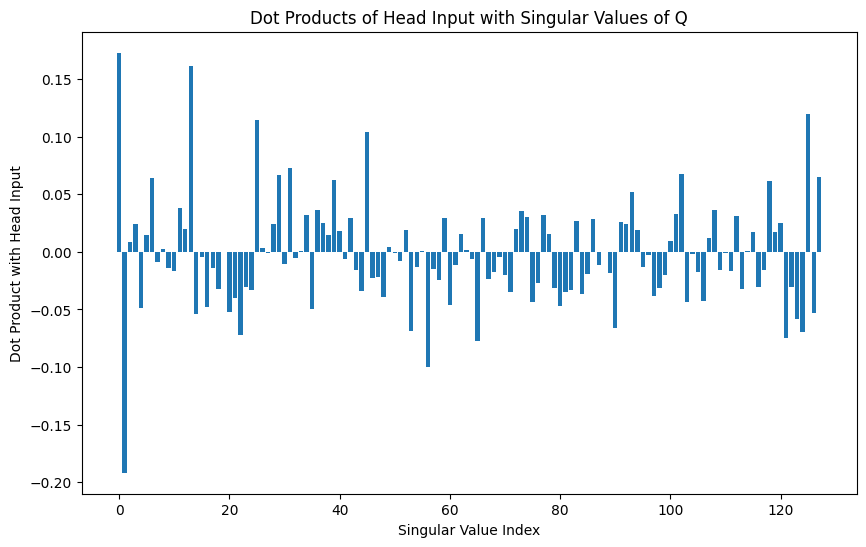

In [ ]:
head_input @ U[:, 0]

# plot the head input's dot products with q singular values 
def plot_head_input_dot_products_with_singular_values(head_input, U):
    """
    Plots the dot products of the head input with the singular values of Q.
    
    Args:
        head_input (torch.Tensor): The head input vector.
        U (torch.Tensor): The left singular vectors of Q.
    """
    dot_products = torch.einsum('i j, i -> j', U, head_input)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(dot_products)), dot_products.cpu().numpy())
    plt.xlabel('Singular Value Index')
    plt.ylabel('Dot Product with Head Input')
    plt.title('Dot Products of Head Input with Singular Values of Q')
    plt.show()


plot_head_input_dot_products_with_singular_values(head_input, U)

In [ ]:
import torch

def randomized_svd(A: torch.Tensor, k: int,
                   n_oversamples: int = 10,
                   n_iter: int = 2) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Randomized SVD: approximate top-k singular values/vectors of A.

    Args:
        A           : (m, n) input matrix
        k           : number of singular values/vectors
        n_oversamples: extra dims for better accuracy (10–20 is common)
        n_iter      : number of power iterations (2–4 is common)

    Returns:
        U      : (m, k) left singular vectors
        S      : (k,) singular values (descending)
        Vt     : (k, n) right singular vectors transposed
    """
    m, n = A.shape
    p = k + n_oversamples

    # Stage A: random range finder
    P = torch.randn(n, p, device=A.device, dtype=A.dtype)
    Z = A @ P
    for _ in range(n_iter):
        Z = A @ (A.T @ Z)

    # Orthonormal basis
    Q, _ = torch.linalg.qr(Z, mode="reduced")  # (m, p)

    # Project and compute small SVD
    B = Q.T @ A  # (p, n)
    U_tilde, S, Vt = torch.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde  # (m, p) @ (p, p) → (m, p)

    # Return top k
    return U[:, :k], S[:k], Vt[:k, :]

# —— Example usage ——
if __name__ == "__main__":
    N = 4096
    A = torch.randn(N, N, device="cuda")
    U, S, Vt = randomized_svd(A, k=10)
    print("Top singular values:", S)
    print("U shape:", U.shape, "Vt shape:", Vt.shape)


Top singular values: tensor([116.5472, 116.2619, 115.4994, 115.0027, 114.8381, 114.2798, 114.0363,
        113.5289, 113.3766, 112.9781], device='cuda:0')
U shape: torch.Size([4096, 10]) Vt shape: torch.Size([10, 4096])


In [ ]:
import torch

def get_top_k_qk_eigen(Q: torch.Tensor, K: torch.Tensor, k: int):
  """
  Calculates the QK product and finds its top k eigenvalues and eigenvectors.

  Args:
    Q: The Query tensor (shape: [dim, head_dim], e.g., [4096, 128]).
    K: The Key tensor (shape: [dim, head_dim], e.g., [4096, 128]).
    k: The number of top eigenvalues/eigenvectors to return.

  Returns:
    A tuple containing:
      - top_k_eigenvalues (torch.Tensor): The top k eigenvalues, sorted by
          magnitude in descending order. May be complex. Shape: [k].
      - top_k_eigenvectors (torch.Tensor): The corresponding top k eigenvectors
          as columns. May be complex. Shape: [dim, k].

  Raises:
    ValueError: If Q and K do not have compatible shapes for the einsum,
                or if k is not a positive integer.
    RuntimeError: If the eigenvalue decomposition fails.
  """
  if not isinstance(Q, torch.Tensor) or not isinstance(K, torch.Tensor):
    raise TypeError("Q and K must be PyTorch tensors.")
  if Q.shape[1] != K.shape[1]:
    raise ValueError(f"Inner dimensions of Q ({Q.shape[1]}) and K ({K.shape[1]}) must match.")
  if Q.shape[0] != K.shape[0]:
      # The einsum 'i j, k j -> i k' results in a matrix of shape [Q.shape[0], K.shape[0]]
      # Eigen decomposition requires a square matrix.
      raise ValueError(f"Outer dimensions of Q ({Q.shape[0]}) and K ({K.shape[0]}) must match for a square product matrix.")
  if not isinstance(k, int) or k <= 0:
      raise ValueError("k must be a positive integer.")

  dim = Q.shape[0]
  if k > dim:
      print(f"Warning: k ({k}) is greater than the matrix dimension ({dim}). Returning all {dim} eigenvalues/eigenvectors.")
      k = dim # Return all if k is too large

  print(f"Calculating QK product for Q: {Q.shape}, K: {K.shape}...")
  # 'i j, k j -> i k' is equivalent to Q @ K.T
  # Q (dim, head_dim), K (dim, head_dim) -> QK_prod (dim, dim)
  # Example: Q(4096, 128), K(4096, 128) -> QK_prod(4096, 4096)
  QK_prod = torch.einsum('i j, k j -> i k', Q, K)
  print(f"QK_prod shape: {QK_prod.shape}")

  print(f"Calculating eigenvalues and eigenvectors for the {QK_prod.shape} matrix...")
  # Use torch.linalg.eig for non-Hermitian matrices (QK_prod is generally not symmetric)
  # This returns potentially complex eigenvalues and eigenvectors
  try:
    eigenvalues, eigenvectors = torch.linalg.eig(QK_prod)
  except RuntimeError as e:
      print(f"Error during eigenvalue decomposition: {e}")
      raise e

  print("Sorting eigenvalues by magnitude...")
  # Sort eigenvalues by magnitude (absolute value) in descending order
  # Eigenvalues can be complex, so we use abs() for magnitude
  magnitudes = torch.abs(eigenvalues)
  sorted_indices = torch.argsort(magnitudes, descending=True)

  # Select the top k indices
  top_k_indices = sorted_indices[:k]

  # Get the top k eigenvalues and eigenvectors using the indices
  top_k_eigenvalues = eigenvalues[top_k_indices]
  # Eigenvectors are returned as columns, so index the columns
  top_k_eigenvectors = eigenvectors[:, top_k_indices]

  print(f"Returning top {k} eigenvalues and eigenvectors.")
  return top_k_eigenvalues, top_k_eigenvectors


In [ ]:
vals, vecs = get_top_k_qk_eigen(Q, K, k=1)

Calculating QK product for Q: torch.Size([4096, 128]), K: torch.Size([4096, 128])...
QK_prod shape: torch.Size([4096, 4096])
Calculating eigenvalues and eigenvectors for the torch.Size([4096, 4096]) matrix...


In [ ]:
vals, vecs = topk_eig_large(M=K.cpu(), N=Q.T.cpu(), k=128)

/tmp/ipykernel_549/3876481693.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return M @ (N @ x)


KeyboardInterrupt: 

In [ ]:
import torch
from transformer_lens import HookedTransformer
from typing import Literal

def get_head_input_vectors(
    model: HookedTransformer,
    prompt: str,
    layer: int,
    head: int,
    token_index: int,
    device: str = None,
) -> dict:
    """
    Returns the query, key, and value vectors for a specific head and token.

    Args:
        model: HookedTransformer
        prompt: str
        layer: int (0-indexed layer number)
        head: int (0-indexed head number)
        token_index: int (token position in prompt, after tokenization)
        device: torch.device or str

    Returns:
        dict with keys 'q', 'k', 'v': each is a tensor of shape [head_dim]
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    tokens = model.to_tokens(prompt).to(device)  # shape [1, seq]
    _, cache = model.run_with_cache(tokens)

    # head input vectors before attention matmul
    qkv_input = cache["qkv_input", layer][0]         # shape [seq, model_dim]
    W_Q = model.W_Q[layer][head]                     # shape [head_dim, model_dim]
    W_K = model.W_K[layer][head]
    W_V = model.W_V[layer][head]

    x = qkv_input[token_index]                       # shape [model_dim]
    q = W_Q @ x                                      # [head_dim]
    k = W_K @ x
    v = W_V @ x

    return {"q": q.detach().cpu(), "k": k.detach().cpu(), "v": v.detach().cpu()}


array([[-0.01110502, -0.01312473, -0.00116576, -0.01218387,  0.00347165],
       [ 0.01622734, -0.01282926,  0.01357685,  0.01148765,  0.00019322],
       [-0.01559521, -0.03206226,  0.00079083, -0.01504059,  0.02223684],
       ...,
       [-0.00784967,  0.00330472, -0.00405071,  0.00843777, -0.03740014],
       [ 0.00380774, -0.00249471, -0.010211  , -0.0037384 ,  0.00566219],
       [ 0.00032165,  0.00207539,  0.00041376,  0.01405454, -0.01689415]],
      shape=(4096, 5), dtype=float32)

In [ ]:
vals

array([-2.2622857, -1.7879766, -1.5893271, -1.4797965, -1.4460055],
      dtype=float32)

In [ ]:
# extract the key query matrices for a specific attention head

def extract_key_query_matrices(model, layer_idx, head_idx, prompt):
    Q = model.blocks[layer_idx].attn.W_Q[head_idx]
    K = model.blocks[layer_idx].attn.W_K[head_idx]